Loaded 400000 word vectors from GloVe.


D:\Anaconda3\envs\airline_sentiment\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

Epoch 1/5
366/366 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.6653 - loss: 0.7983 - val_accuracy: 0.7732 - val_loss: 0.5626
Epoch 2/5
366/366 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.7606 - loss: 0.5970 - val_accuracy: 0.7889 - val_loss: 0.5293
Epoch 3/5
366/366 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.7804 - loss: 0.5460 - val_accuracy: 0.7824 - val_loss: 0.5691
Epoch 4/5
366/366 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.7890 - loss: 0.5311 - val_accuracy: 0.8050 - val_loss: 0.5050
Epoch 5/5
366/366 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.8130 - loss: 0.4851 - val_accuracy: 0.8043 - val_loss: 0.5051
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8044 - loss: 0.5011
Test Accuracy: 0.8043


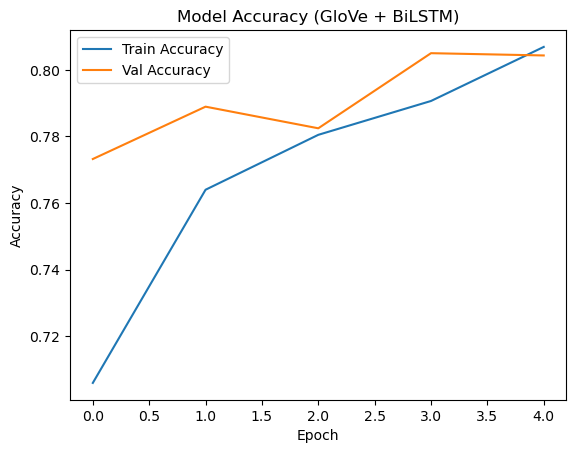

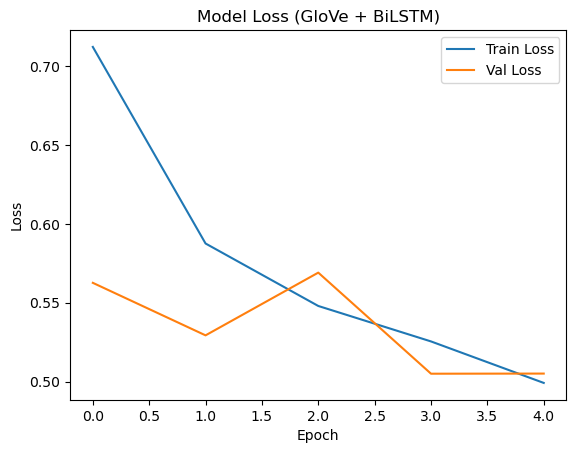

92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step  
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1889
           1       0.67      0.53      0.59       580
           2       0.80      0.63      0.71       459

    accuracy                           0.80      2928
   macro avg       0.77      0.70      0.73      2928
weighted avg       0.80      0.80      0.80      2928



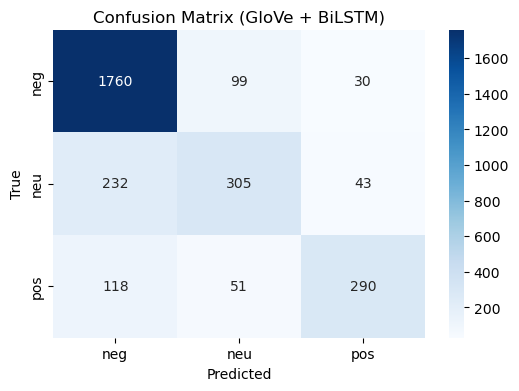

In [2]:
# 📘 04_BiLSTM_GloVe_Model.ipynb

# ✅ 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import load_model
import os

# ✅ Import shared preprocessing
from shared_preprocessing import preprocess_data, save_tokenizer_and_encoder

# ✅ 2. Load and Preprocess Data
path = "D:/Sentimental-Analysis/data/Tweets.csv"
df = pd.read_csv(path)
X, y, tokenizer, label_encoder = preprocess_data(df)

# ✅ 3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ 4. Load GloVe Embeddings
glove_path = "D:/Sentimental-Analysis/data/glove.6B.100d.txt"
embedding_index = {}

with open(glove_path, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f"Loaded {len(embedding_index)} word vectors from GloVe.")

# ✅ 5. Create Embedding Matrix
vocab_size = 10000
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

word_index = tokenizer.word_index
for word, i in word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# ✅ 6. Build Bi-LSTM Model with GloVe
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=50,
                    trainable=False))  # Freeze GloVe weights
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# ✅ 7. Train the Model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

# ✅ 8. Evaluate
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

# ✅ 9. Save Model and Tokenizer/Encoder
model.save("sentiment_bilstm_glove_model.keras")
save_tokenizer_and_encoder(tokenizer, label_encoder)

# ✅ 10. Plot Accuracy & Loss
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy (GloVe + BiLSTM)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss (GloVe + BiLSTM)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# ✅ 11. Classification Report & Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes))

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['neg', 'neu', 'pos'], yticklabels=['neg', 'neu', 'pos'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (GloVe + BiLSTM)")
plt.show()

# ✅ 12. Load Model (Optional)
model = load_model("sentiment_bilstm_glove_model.keras")